单一模型的均方误差
 [0.04660426814538745, 0.05821801725661683, 0.07955317296262081, 0.03985076192077574, 0.04758847134066618]


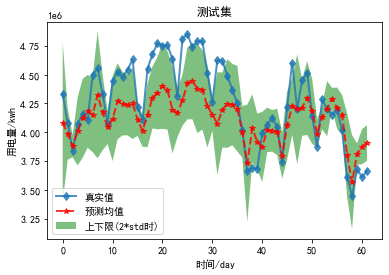

组合模型的均方误差
   0.047930295928720376


In [15]:
import matplotlib.pyplot as plt
from pylab import *
import matplotlib;#matplotlib.use('TkAgg')
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import numpy as np
import pandas as pd


#计算相对于实际值的预测值的绝对百分误差(MAPE)
def mape(actual,pred):
	if (not len(actual) == len(pred) or len(actual) == 0):
		return -1.0
	total = 0.0
	for x in range(len(actual)):
		total += abs((actual[x]-pred[x])/actual[x])
	return total/len(actual)


data = pd.read_csv('total_df.csv')  # 读取负荷
data.columns = data.columns.str.replace('Unnamed: 0', '序号') #给第一列赋名为序号
del data['序号']  # 删除 序号列，这一列是多余的

total_df=data.copy()
total_df.loc[:,'record_date']=pd.to_datetime(total_df['record_date'])
## 分离训练集和测试集
#将2016年7月以前的数据为训练集，2016年7月后为测试集。（取2个月为测试集
train_x = total_df[total_df.record_date<'2016-7-01'] #[547 rows x 146 columns]
train_y = total_df[total_df.record_date<'2016-7-01']['power_consumption']
train_y=np.array(train_y)#(547,)
test_x = total_df[total_df.record_date>='2016-7-01']
test_y=total_df[total_df.record_date>='2016-7-01']['power_consumption']
test_y=np.array(test_y)#(62,)
# x去掉'record_date', 'power_consumption'两列
drop_columns = ['record_date', 'power_consumption']
train_x = train_x.drop(drop_columns, axis=1)#[547 rows x 144 columns]
test_x = test_x.drop(drop_columns, axis=1)#[62 rows x 144 columns]



###区间预测


####1决策树回归####
from sklearn import tree
model_DecisionTreeRegressor = tree.DecisionTreeRegressor()

####2SVR回归####
from sklearn.svm import SVR
model_SVR=SVR(C=1.0, epsilon=0.2)
####3KNN回归####
from sklearn import neighbors
model_KNeighborsRegressor = neighbors.KNeighborsRegressor()

####4随机森林回归####
from sklearn import ensemble
model_RandomForestRegressor = ensemble.RandomForestRegressor(n_estimators=20)#这里使用20个决策树

####5Adaboost回归####
from sklearn import ensemble
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(n_estimators=50)#这里使用50个决策树

####6GBRT回归####
from sklearn import ensemble
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(n_estimators=100)#这里使用100个决策树
####7Bagging回归####
from sklearn.ensemble import BaggingRegressor
model_BaggingRegressor = BaggingRegressor()


def model_reg(X_train, y_train, X_val, y_val):
    clfs = [model_DecisionTreeRegressor, model_KNeighborsRegressor, model_AdaBoostRegressor,
            model_GradientBoostingRegressor,
            model_BaggingRegressor]#model_SVR,
    losses = []
    y_predict=[]
    for clf in clfs:#遍历每一个模型

        clf.fit(X_train, y_train)
        y_predict_val = clf.predict(X_val)#预测
        y_predict.append(y_predict_val)

        losses.append(mape(y_val,y_predict_val) )#计算每棵树预测的mse误差
    return losses,y_predict
losses_1,y_predict = model_reg(train_x, train_y, test_x, test_y)
print('单一模型的均方误差\n',losses_1)
y_predict=np.array(y_predict)
y_mean=y_predict.mean(axis=0)
y_stv=y_predict.std(axis=0)#方差
y_mean_1=y_mean-2*y_stv#下限
y_mean_2=y_mean+2*y_stv#上限



x1=np.arange(len(test_x))


plt.plot(test_y,marker='d',linestyle='-',linewidth=2,alpha=0.8,label='真实值')
plt.plot(y_mean,color='r',marker='*',linestyle='--',linewidth=2,alpha=0.8,label='预测均值')
plt.fill_between(x1 ,y_mean_1, y_mean_2, facecolor="green",alpha=.5,label='上下限(2*std时)')
plt.xlabel('时间/day')
plt.ylabel('用电量/kwh')
plt.title('测试集')
plt.legend()
plt.show()

#打印误差
MAPE=mape(test_y,y_mean)
print('组合模型的均方误差\n  ', MAPE)